In [1]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

Using TensorFlow backend.


In [2]:
from PIL import Image

In [30]:
#for data augmentation (normalization,whitening,ZCA,rotation)
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

img = load_img('car-damage-dataset/data1a/training/00-damage/0039.JPEG') # this is a PIL image 
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)


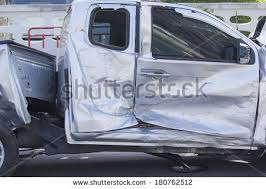

In [33]:
im = Image.open("car-damage-dataset/data1a/training/00-damage/0039.JPEG")
im

In [8]:
#os.makedirs('car-damage-dataset/data1a/training_augmented/00-damage/')
#generates <batches> new images 
batches = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='car-damage-dataset/data1a/training_augmented/00-damage/', save_prefix='00-damage', save_format='jpeg'):
        batches += 1
        if batches > 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break


In [50]:
225 * 1./225

1.0

In [52]:
def load_vgg16(weights_path='vgg16.h5', img_width = 256, img_height = 256):
    model = Sequential() #The Sequential model is a linear stack of layers.
    #128x128 -[pad 1]-> 130x130 -[3x3 conv]-> 128x128 -[2x2 pool]-> 64x64 -[pad+conv+pool]-> 32x32 -[...]-> 16x16 -> 8x8 ...

    
    #first layer must have input shape. 
    #This layer can add rows and columns of zeros at the top, bottom, left and right side of an image tensor.
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height))) 
    
    
    #3x3 64. Use padding to allow division by two
    model.add(Convolution2D(64, 3, 3, activation='relu')) 
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #3x3 128. Use padding to allow division by two
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #3x3 256. Use padding to allow division by two
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #3x3 512. Use padding to allow division by two
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #3x3 512. Use padding to allow division by two
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
      
    #stop before flattern and full connected layers    
    
    #si carica i weights sui livelli di convoluzione da un modello che aveva precedentemente salvato. non configura la parte di dense layer
    """if weights_path:

    # loads the weights of the VGG16 networks
    # note: when there is a complete match between model definition
    # and your weights savefile, you can simply call model.load_weights(filename)
        f = h5py.File(weights_path)
        for k in range(f.attrs['nb_layers']):
            if k >= len(model.layers): 
                # we don't look at the last (fully-connected) layers in the savefile
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)
        f.close()
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.') """

    return model

In [73]:
"""In transfer learning,
we take a pre-trained model (network + weights), and then removes the FC network,
and construct our own in place of it.
Doing so, it will remove the pre-trained weights at those layers.
Now the original network before the FC network is frozen so that, 
when the training is start on the new data set,
only the newly added FC network are trained. 
Here the input to the FC network is called the bottleneck features."""

def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  #rescaled image 
    
    model = load_vgg16() #first part (only convolutional layers) of vgg16 with weights pretrined (kernel weights)
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    
    #make inference on training data rescaled. Siccome il modello è solo kernel convoluzionario restituirà le immagini dei training dopo l'applicazione dei filtri
    #che saranno le feature di input (bottleneck feature) del classificatore che faremo dopo 
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train) # save bottleneck features
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation) # save bottleneck features

In [14]:
def train_binary_model():

    train_data = np.load(open(location+'/bottleneck_features_train.npy'))  #bottleneck feature to pass to flatten and dense layers
    train_labels = np.array([0] * train_samples[0] + #build label related to training (0 whole, 1 damaged)
                            [1] * train_samples[1])

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))  #what is the shape????
    model.add(Dense(256, activation = 'relu', W_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid')) # should activation be sigmoid for binary problem????

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
    #train and evaluate model
    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    #save accuracy and loss for each epoch
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history #return the model and log history

In [ ]:
def finetune_binary_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path of dense layer. In this path there are better weights

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

# Init

In [7]:
# path to the model weights file
location = 'car-damage-dataset/data1a'
top_model_weights_path= location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples) #total number of pictures for training (whole + demaged)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples) #total number of pictures for validation/test (whole + demaged)

nb_epoch = 50

In [ ]:
save_bottleneck_features(location) #create vgg16 convolutional layer with pre-trained weights (ImageNet dataset)
                                   #take the images (data1a: 00-damage, 01-whole) and generate bottleneck features using above convolutional layer

In [ ]:
d1a_model1, d1a_history1 = train_binary_model() #read the bottleneck feature generate at previous step and use them to train the dense layer
d1a_model2, d1a_history2 = train_binary_model() # more than couple of times
d1a_model3, d1a_history3 = train_binary_model()
d1a_model4, d1a_history4 = train_binary_model()
d1a_model5, d1a_history5 = train_binary_model()
d1a_model6, d1a_history6 = train_binary_model()
d1a_model7, d1a_history7 = train_binary_model()

ft_model, ft_history = finetune_binary_model() # load imageNet weights from VGG16 pre-trained model for Conv layers, load previous weights for dense layers. Learning rate slower and train/test with only data augmentations
